In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [3]:
train_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/first/"
test_image_path = "/home/chisc/workspace/wuzhenrong/galaxy/test/"

In [4]:
batch_size = 32
torch.manual_seed(0) # random seed
# E type :250
# I type :196
# Sc type :569
train_trans = transforms.Compose([transforms.Resize((255, 255)), 
                                  transforms.ToTensor()
                                 ])
class_weights = [250/1015, 196/1015, 569/1015]
weights = 1. / torch.tensor(class_weights, dtype=torch.float)
print(weights)
sampler = WeightedRandomSampler(weights=weights, num_samples=len(weights))
train_data = ImageFolder(train_image_path, transform = train_trans)
train_set_size = int(len(train_data) * 0.89)
valid_set_size = len(train_data) - train_set_size

train_set, valid_set = torch.utils.data.random_split(train_data, [train_set_size, valid_set_size])
train_loader = DataLoader(train_set, batch_size = batch_size, pin_memory = True)

print(len(train_set))
val_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
# val_data = ImageFolder(test_image_path, transform = val_trans)
val_loader = DataLoader(valid_set)
print(len(valid_set))
test_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data)

tensor([4.0600, 5.1786, 1.7838])
903
112


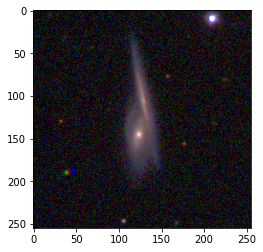

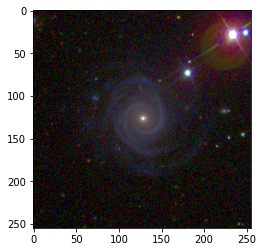

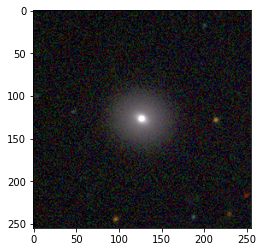

In [5]:
images, labels = next(iter(train_loader))

# for i in np.arange(3):
#   plt.figure(i)
#   plt.imshow(images[i].permute(1, 2, 0))
#   plt.show()

# After Normalize
for i in np.arange(3):
  plt.figure(i)
  plt.imshow(images[i].permute(1, 2, 0))
  plt.show()
# Before Normalize
# for i in np.arange(3):
#   plt.figure(i)
#   # Our data are normalized, in order to watch our origin image, so we need to denormalize our data
#   mean = torch.tensor([0.485, 0.456, 0.406])
#   std = torch.tensor([0.229, 0.224, 0.225])
#   tmp = transforms.Normalize(-mean/std, 1/std)(images[i]) # denormalize
#   plt.imshow(tmp.permute(1, 2, 0)) # The data in pytorch is (channel, size, size), and we need to change it to (size, size, channel)
#   plt.show()

In [6]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 128), # Fully-connected layer
        nn.Dropout(0.4), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(128, 3)
    )
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    return x

In [7]:
model = Galaxy()
# model = torchvision.models.vgg16()
model = model.to(device)
print(model)

Galaxy(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=25088, out_features=128, bias=Tru

In [8]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()

n_epochs = 40
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    model.train()

    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = model(x)
        loss = loss_func(prediction, y)
        loss.backward()
        optimizer.step()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(train_loader)
        train_loss += loss/len(train_loader)

    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss)
    train_acc_record.append(train_acc)

    model.eval()
    for x, y in tqdm(val_loader):
        x, y = x.to(device), y.to(device)
        prediction = model(x)
        loss = loss_func(prediction, y)
        loss.backward()
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        val_acc += acc/len(val_loader)
        val_loss += loss/len(val_loader)
        if loss < min_loss:
            min_loss = loss
            torch.save(model, 'E_I_Sc_new.pkl')
    print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
    val_loss_record.append(val_loss)
    val_acc_record.append(val_acc)
# torch.save(model, 'E_I_Sc.pkl')

  0%|          | 0/29 [00:00<?, ?it/s]

/home/chisc/.pyenv/versions/torch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[ Train | 1/40 ] loss = 1.04318, acc = 0.52956


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 1/40 ] loss = 0.93362, acc = 0.61607


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 2/40 ] loss = 0.99984, acc = 0.56188


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 2/40 ] loss = 0.87371, acc = 0.61607


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 3/40 ] loss = 0.95422, acc = 0.56081


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 3/40 ] loss = 0.80528, acc = 0.61607


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 4/40 ] loss = 0.84342, acc = 0.65009


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 4/40 ] loss = 0.66400, acc = 0.75000


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 5/40 ] loss = 0.83864, acc = 0.64701


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 5/40 ] loss = 0.62392, acc = 0.76786


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 6/40 ] loss = 0.73740, acc = 0.70197


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 6/40 ] loss = 0.54985, acc = 0.72321


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 7/40 ] loss = 0.65250, acc = 0.72568


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 7/40 ] loss = 0.42825, acc = 0.87500


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 8/40 ] loss = 0.55816, acc = 0.77263


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 8/40 ] loss = 0.39328, acc = 0.87500


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 9/40 ] loss = 0.44755, acc = 0.82697


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 9/40 ] loss = 0.42570, acc = 0.85714


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 10/40 ] loss = 0.40542, acc = 0.86638


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 10/40 ] loss = 0.41142, acc = 0.85714


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 11/40 ] loss = 0.42487, acc = 0.84960


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 11/40 ] loss = 0.30861, acc = 0.89286


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 12/40 ] loss = 0.36525, acc = 0.88470


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 12/40 ] loss = 0.28847, acc = 0.89286


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 13/40 ] loss = 0.38521, acc = 0.87716


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 13/40 ] loss = 0.34232, acc = 0.86607


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 14/40 ] loss = 0.31868, acc = 0.89009


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 14/40 ] loss = 0.29394, acc = 0.88393


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 15/40 ] loss = 0.32741, acc = 0.88685


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 15/40 ] loss = 0.37033, acc = 0.83929


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 16/40 ] loss = 0.31230, acc = 0.90625


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 16/40 ] loss = 0.28214, acc = 0.90179


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 17/40 ] loss = 0.28961, acc = 0.91703


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 17/40 ] loss = 0.29764, acc = 0.86607


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 18/40 ] loss = 0.31645, acc = 0.89871


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 18/40 ] loss = 0.39658, acc = 0.85714


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 19/40 ] loss = 0.29989, acc = 0.90025


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 19/40 ] loss = 0.35456, acc = 0.90179


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 20/40 ] loss = 0.30452, acc = 0.89917


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 20/40 ] loss = 0.32389, acc = 0.89286


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 21/40 ] loss = 0.35569, acc = 0.87377


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 21/40 ] loss = 0.28206, acc = 0.87500


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 22/40 ] loss = 0.36243, acc = 0.88085


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 22/40 ] loss = 0.28471, acc = 0.90179


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 23/40 ] loss = 0.28168, acc = 0.90194


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 23/40 ] loss = 0.30750, acc = 0.87500


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 24/40 ] loss = 0.25899, acc = 0.90779


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 24/40 ] loss = 0.21696, acc = 0.92857


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 25/40 ] loss = 0.24654, acc = 0.91703


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 25/40 ] loss = 0.29635, acc = 0.90179


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 26/40 ] loss = 0.25233, acc = 0.91487


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 26/40 ] loss = 0.25908, acc = 0.92857


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 27/40 ] loss = 0.27257, acc = 0.91102


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 27/40 ] loss = 0.23995, acc = 0.92857


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 28/40 ] loss = 0.28109, acc = 0.90948


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 28/40 ] loss = 0.25255, acc = 0.91964


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 29/40 ] loss = 0.22337, acc = 0.92349


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 29/40 ] loss = 0.31865, acc = 0.89286


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 30/40 ] loss = 0.22125, acc = 0.93319


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 30/40 ] loss = 0.31322, acc = 0.89286


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 31/40 ] loss = 0.24254, acc = 0.92349


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 31/40 ] loss = 0.24280, acc = 0.89286


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 32/40 ] loss = 0.22034, acc = 0.93642


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 32/40 ] loss = 0.38733, acc = 0.86607


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 33/40 ] loss = 0.21740, acc = 0.94073


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 33/40 ] loss = 0.30861, acc = 0.88393


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 34/40 ] loss = 0.21192, acc = 0.94612


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 34/40 ] loss = 0.34120, acc = 0.87500


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 35/40 ] loss = 0.20653, acc = 0.92780


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 35/40 ] loss = 0.29944, acc = 0.91072


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 36/40 ] loss = 0.21724, acc = 0.93103


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 36/40 ] loss = 0.30657, acc = 0.87500


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 37/40 ] loss = 0.21176, acc = 0.93150


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 37/40 ] loss = 0.28666, acc = 0.88393


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 38/40 ] loss = 0.23699, acc = 0.92888


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 38/40 ] loss = 0.34570, acc = 0.87500


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 39/40 ] loss = 0.20862, acc = 0.93473


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 39/40 ] loss = 0.25885, acc = 0.91072


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 40/40 ] loss = 0.21087, acc = 0.93750


  0%|          | 0/112 [00:00<?, ?it/s]

[ Validation | 40/40 ] loss = 0.28212, acc = 0.92857


In [10]:
actu = []
ai_pred = []
model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    actu.append(y.to('cpu').numpy()[0])
    ai_pred.append(prediction.argmax().to('cpu').numpy())
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(val_loader)
    test_loss += loss/len(val_loader)
print(f"[ Test ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")

[ Test ] loss = 0.28212, acc = 0.92857


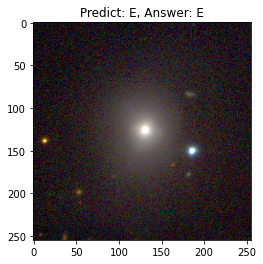

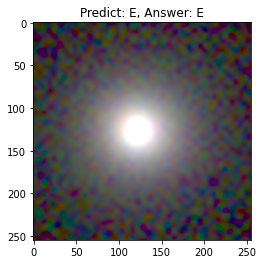

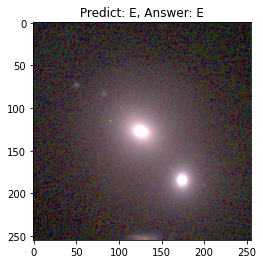

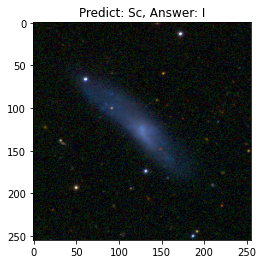

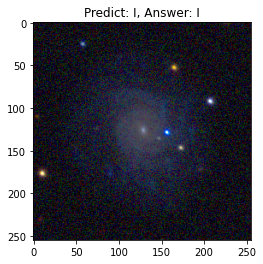

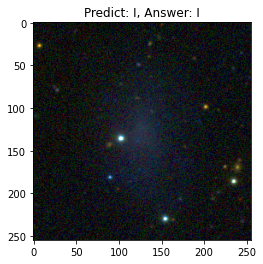

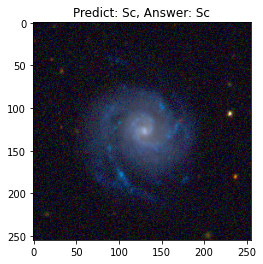

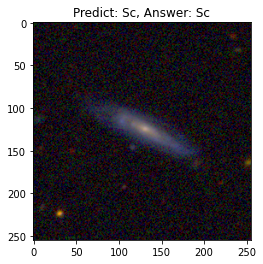

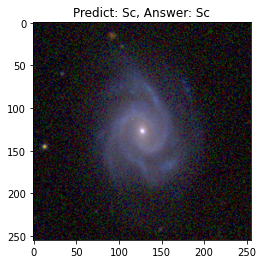

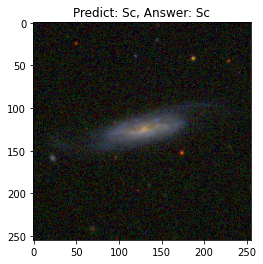

In [11]:
i = 0
for x, y in test_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)
    out = output.argmax(dim = 1)
    out = out.to('cpu').numpy()
    # print(out)
    if y == 0:
        ans = 'E'
    elif y == 1:
        ans = 'I'
    else:
        ans = 'Sc'
    if i % 10 == 0:
        plt.figure(i)
        if out[0] == 0:
            plt.title(f'Predict: E, Answer: {ans}')
        elif out[0] == 1:
            plt.title(f'Predict: I, Answer: {ans}')
        else:
            plt.title(f'Predict: Sc, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
#     mean = torch.tensor([0.485, 0.456, 0.406])
#     std = torch.tensor([0.229, 0.224, 0.225])
#     tmp = transforms.Normalize(-mean/std, 1/std)(images[i]) # denormalize
        plt.imshow(x.permute(1, 2, 0))
        plt.show()

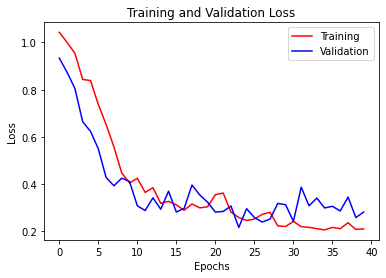

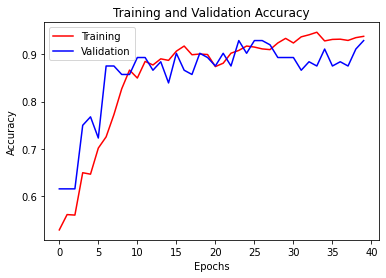

In [12]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [13]:
answer = pd.Series(actu, name='Actual')
pred = pd.Series(ai_pred, name='Predicted', dtype = 'int64')
df_confusion = pd.crosstab(answer, pred, rownames=['True'], colnames=['Predicted'], margins=True)

In [14]:
def plot_confusion_matrixs(df_confusion, title='Confusion matrix', cmap=plt.cm.hot):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

/tmp/ipykernel_28300/974452671.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


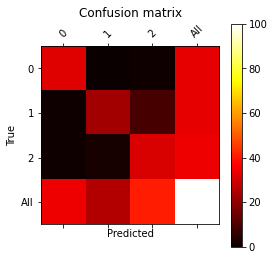

In [15]:
plot_confusion_matrixs(df_confusion);